In [82]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [83]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


In [84]:


file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date",
                         "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_fmri_and_pregnancy_days_difference
newborn_birth_date
Days_from_Birth_to_Questionnaire_Completion
Demographics_Date
date_of_bir

In [85]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9'
                                                                                               ,'b_PHQ_10',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9','t1_PHQ_10',
               't2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9','t2_PHQ_10',
               't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9','t3_PHQ_10',
               'after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9','after_PHQ_10']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
               't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
               't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
               't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
               'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']

the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [86]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("data/q_data/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_PHQ_10', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_PHQ_10', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_PHQ_10', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_PHQ_10', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_PHQ_10', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3

In [87]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'data/q_data/time_points/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'data/q_data/time_points/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'data/q_data/time_points/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'data/q_data/time_points/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'data/q_data/time_points/after_questionnaire')



✅ נוצר הקובץ: data/q_data/time_points/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 141
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_PHQ_10, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: data/q_data/time_points/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 139
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_PHQ_10, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: data/q_data/time_points/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 133
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_PHQ_10, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: data/q_data/time_points/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 121
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PHQ_8,

In [92]:
q_before = 'data/q_data/time_points/b_questionnaire.csv'
q_t1  = 'data/q_data/time_points/t1_questionnaire.csv'
q_t2 = 'data/q_data/time_points/t2_questionnaire.csv'
q_t3 = 'data/q_data/time_points/t3_questionnaire.csv'
q_after = 'data/q_data/time_points/after_questionnaire.csv'

f = pd.read_csv(q_before)
print(f.head())
analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)


   Unnamed: 0 Subject_Code  b_PHQ_1  b_PHQ_2  b_PHQ_3  b_PHQ_4  b_PHQ_5  \
0           0        NT005      0.0      2.0      0.0      1.0      1.0   
1           1        NT006      1.0      1.0      1.0      1.0      0.0   
2           2        NT002      1.0      1.0      1.0      3.0      2.0   
3           3        NT003      1.0      1.0      0.0      0.0      0.0   
4           4        NT001      0.0      0.0      1.0      1.0      0.0   

   b_PHQ_6  b_PHQ_7  b_PHQ_8  b_PHQ_9  b_PHQ_10  b_GAD7_1  b_GAD7_2  b_GAD7_3  \
0      1.0      1.0      0.0      0.0       1.0       1.0       0.0       1.0   
1      0.0      1.0      0.0      0.0       1.0       1.0       0.0       1.0   
2      0.0      1.0      0.0      0.0       1.0       1.0       0.0       1.0   
3      0.0      0.0      0.0      0.0       0.0       0.0       0.0       0.0   
4      0.0      0.0      0.0      0.0       0.0       1.0       0.0       1.0   

   b_GAD7_4  b_GAD7_5  b_GAD7_6  b_GAD7_7  
0       0.0       

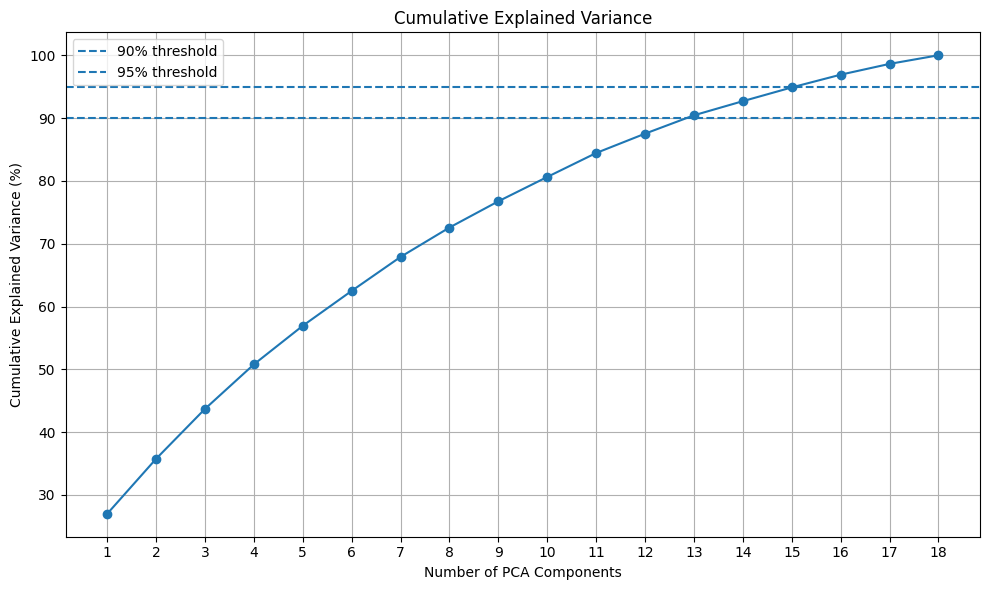

✅ 90% variance: 13 components
✅ 95% variance: 16 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


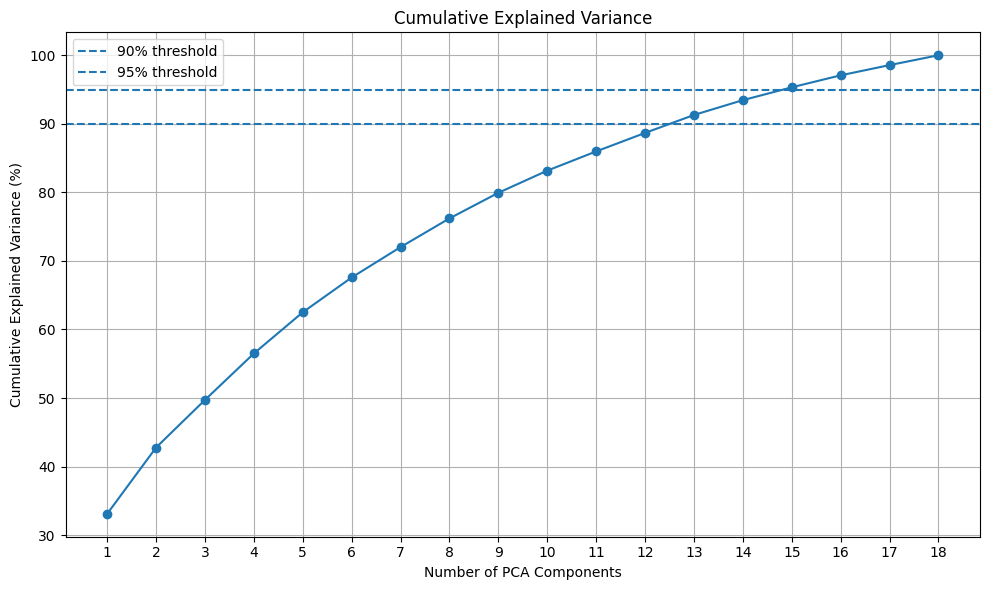

✅ 90% variance: 13 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t1_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


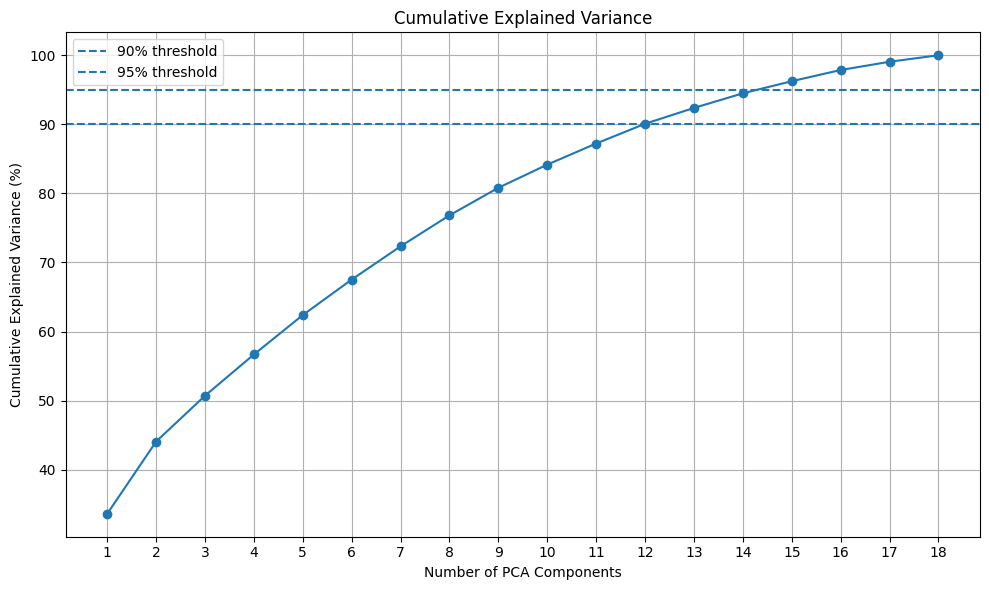

✅ 90% variance: 12 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t2_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


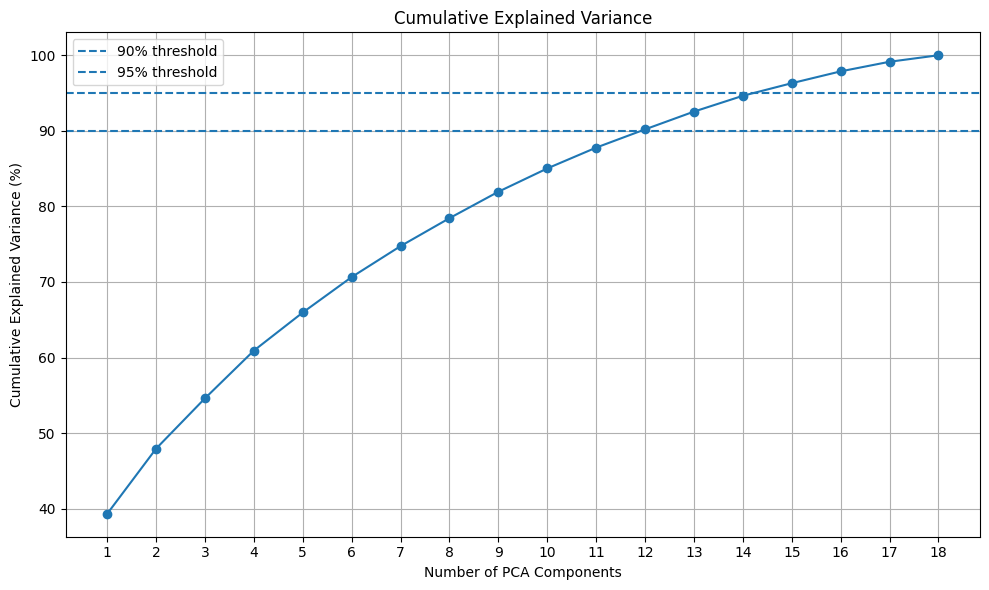

✅ 90% variance: 12 components
✅ 95% variance: 15 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\t3_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


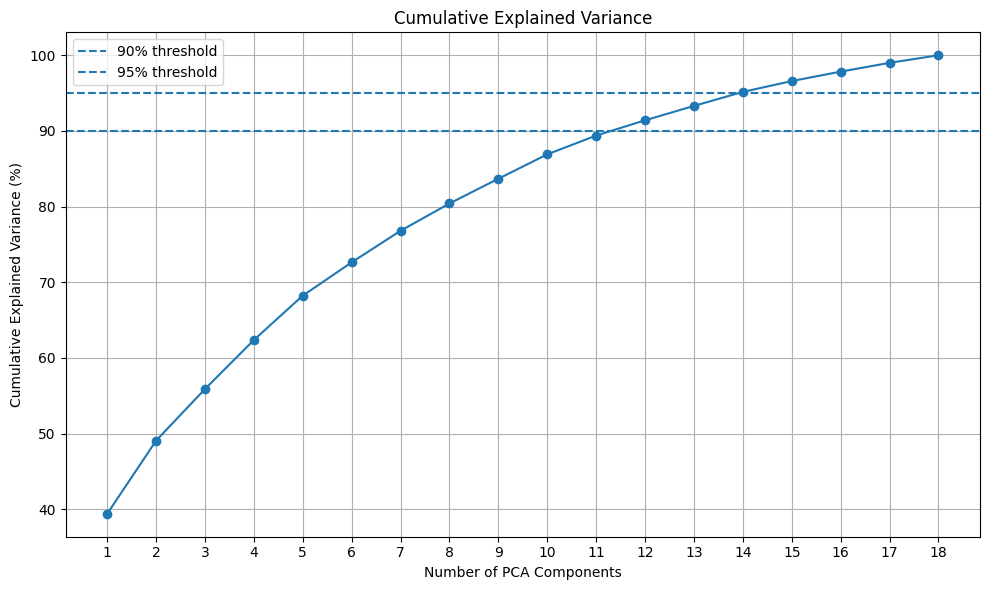

✅ 90% variance: 12 components
✅ 95% variance: 14 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/ses1_figures\after_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 12


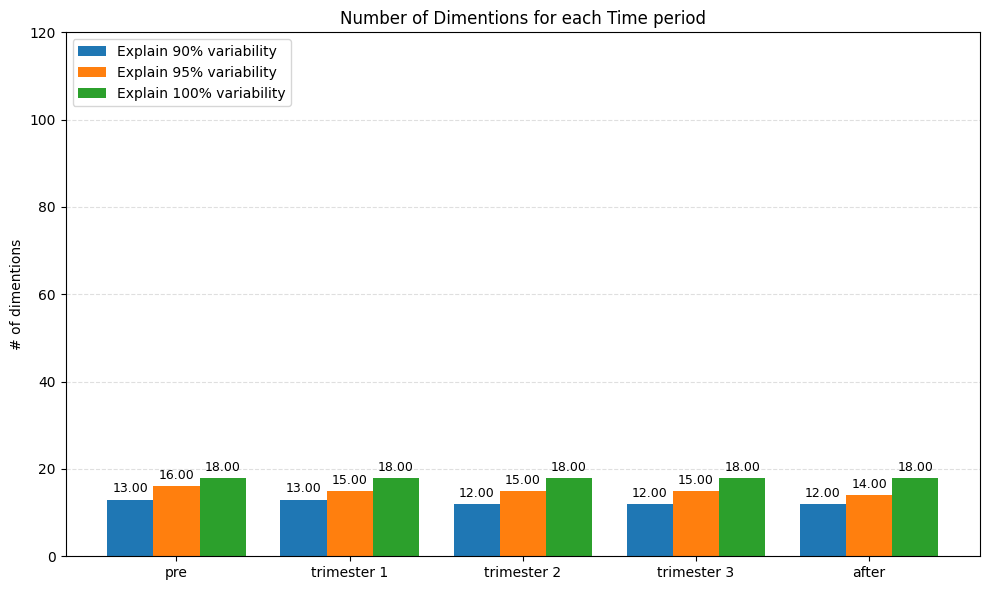

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [89]:
n_dims_b_90, n_dims_b_95, n_dims_b_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_b_90}")

n_dims_t1_90, n_dims_t1_95, n_dims_t1_100 = find_optimal_pca_dimensions(q_t1,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t1_90}")

n_dims_t2_90, n_dims_t2_95, n_dims_t2_100 = find_optimal_pca_dimensions(q_t2,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t2_90}")

n_dims_t3_90, n_dims_t3_95, n_dims_t3_100 = find_optimal_pca_dimensions(q_t3,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_t3_90}")

n_dims_after_90, n_dims_after_95, n_dims_after_100 = find_optimal_pca_dimensions(q_after,save_dir="data/only_Q_outputs/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_after_90}")

groups = ["pre", "trimester 1", "trimester 2", "trimester 3", "after"]
s1 = [n_dims_b_90, n_dims_t1_90, n_dims_t2_90, n_dims_t3_90, n_dims_after_90]  # values for column 1 in each
s2 = [n_dims_b_95, n_dims_t1_95, n_dims_t2_95, n_dims_t3_95, n_dims_after_95]  # values for column 2
s3 = [n_dims_b_100, n_dims_t1_100, n_dims_t2_100, n_dims_t3_100, n_dims_after_100]  # values for column 2

plot_grouped_bars(groups, s1, s2, s3,
                  s1_label="Explain 90% variability",
                  s2_label="Explain 95% variability",
                  s3_label="Explain 100% variability",
                  title="Number of Dimentions for each Time period",
                  ylabel="# of dimentions")



In [90]:
df_b = pd.read_csv(q_before)
df_t1 = pd.read_csv(q_t1)
df_t2 = pd.read_csv(q_t2)
df_t3 = pd.read_csv(q_t3)
df_after =pd.read_csv(q_after)

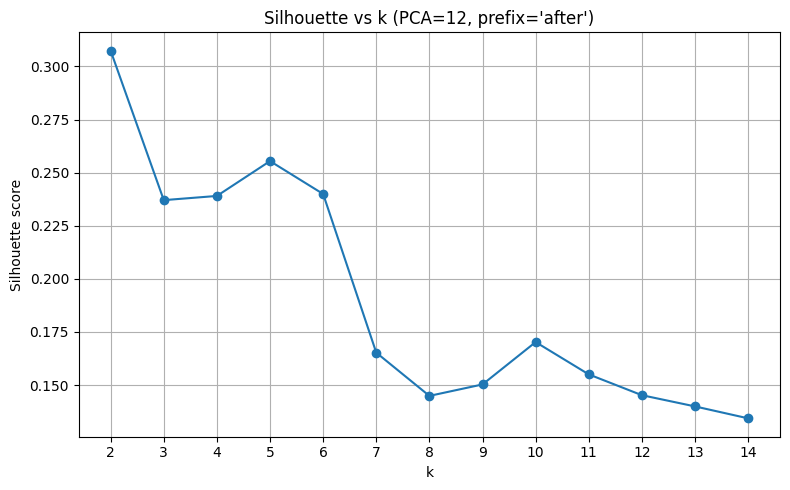


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.531953
1             1        1          -0.082586
2             2        0           0.321534
3             3        0           0.576749
4             4        1          -0.137149
..          ...      ...                ...
120         120        0           0.526093
121         121        0           0.213913
122         122        1           0.221218
123         123        1          -0.063514
124         124        0           0.529300

[125 rows x 3 columns]


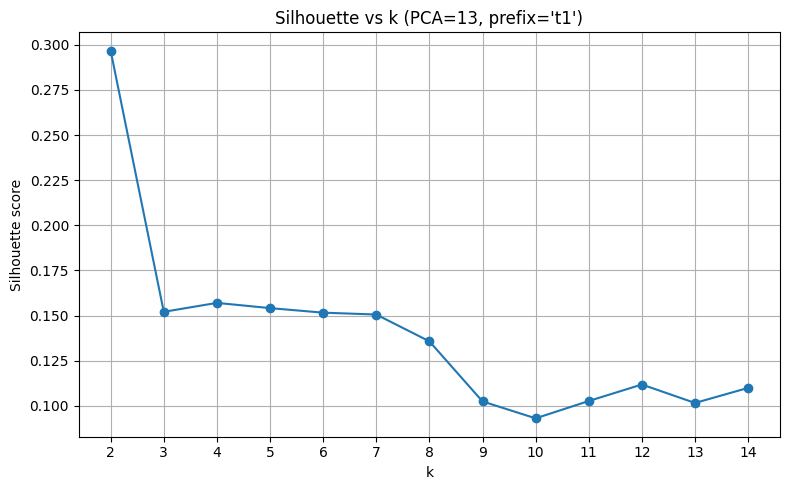


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.296655
1             1        0           0.489418
2             2        0           0.376565
3             3        0           0.515107
4             4        0           0.482482
..          ...      ...                ...
134         134        0           0.217433
135         135        0           0.296068
136         136        0           0.501855
137         137        0           0.323702
138         138        0           0.471464

[139 rows x 3 columns]


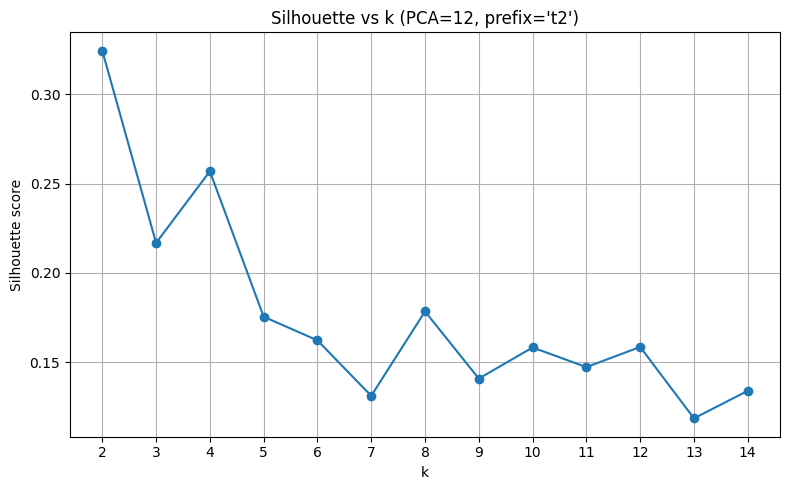


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.359449
1             1        0           0.358262
2             2        0           0.493136
3             3        0           0.555920
4             4        0           0.352612
..          ...      ...                ...
128         128        1           0.143338
129         129        0           0.553317
130         130        1          -0.118421
131         131        0           0.552436
132         132        0           0.508736

[133 rows x 3 columns]


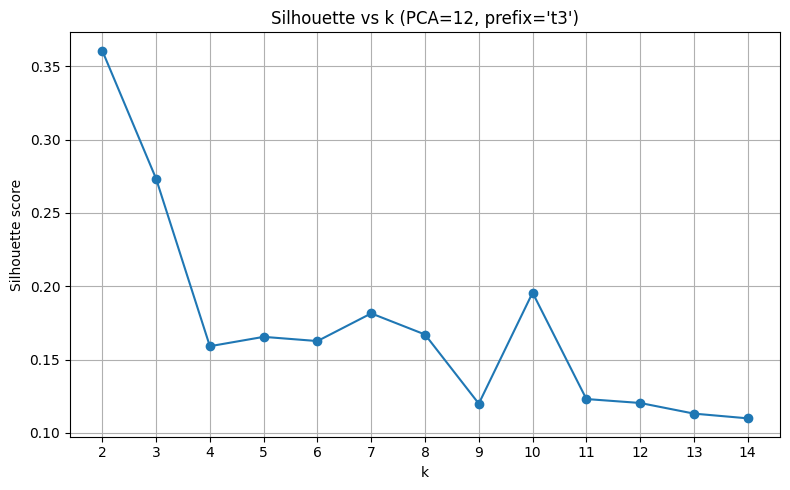


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.421027
1             1        0           0.411055
2             2        0           0.322026
3             3        0           0.601972
4             4        0           0.488121
..          ...      ...                ...
116         116        0           0.338595
117         117        0           0.553018
118         118        0           0.350356
119         119        0           0.516980
120         120        0           0.552206

[121 rows x 3 columns]


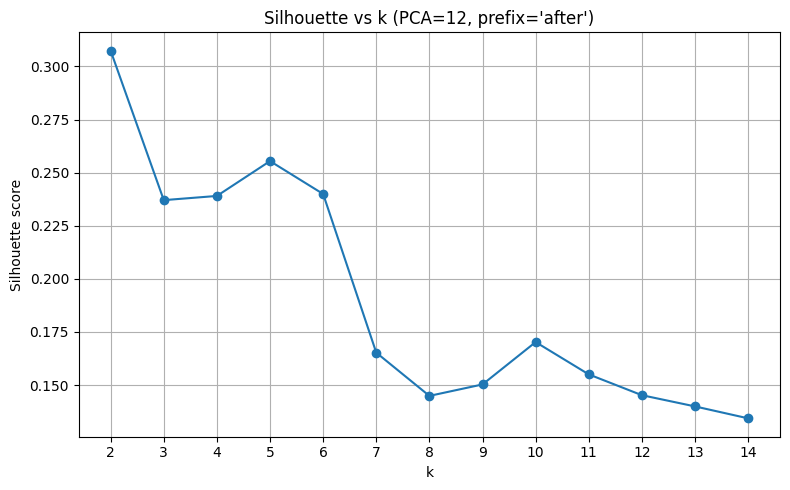


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
     subject_id  cluster  silhouette_sample
0             0        0           0.531953
1             1        1          -0.082586
2             2        0           0.321534
3             3        0           0.576749
4             4        1          -0.137149
..          ...      ...                ...
120         120        0           0.526093
121         121        0           0.213913
122         122        1           0.221218
123         123        1          -0.063514
124         124        0           0.529300

[125 rows x 3 columns]


In [91]:
    res_after = pca_kmeans_minimal_outputs(
        df_after,
        prefix="after",
        n_components=n_dims_after_90,
        k_range=range(2, 15),
        top_k_features=20,
        save_dir="data/only_Q_outputs"
    )


    # You already found that e.g., 22 PCA components explain 95% of variance
    res_t1 = pca_kmeans_minimal_outputs(
        df_t1,
        prefix="t1",
        n_components=n_dims_t1_90,
        k_range=range(2, 15),
        top_k_features=20,
        save_dir="data/only_Q_outputs"
    )


    # Load your Excel file

    # You already found that e.g., 22 PCA components explain 95% of variance
    res_t2 = pca_kmeans_minimal_outputs(
        df_t2,
        prefix="t2",
        n_components=n_dims_t2_90,
        k_range=range(2, 15),
        top_k_features=20,
        save_dir="data/only_Q_outputs")


    # You already found that e.g., 22 PCA components explain 95% of variance
    res_t3 = pca_kmeans_minimal_outputs(
        df_t3,
        prefix="t3",
        n_components=n_dims_t3_90,
        k_range=range(2, 15),
        top_k_features=20,
        save_dir="data/only_Q_outputs",)


    # You already found that e.g., 22 PCA components explain 95% of variance
    res_after = pca_kmeans_minimal_outputs(
        df_after,
        prefix="after",
        n_components=n_dims_after_90,
        k_range=range(2, 15),
        top_k_features=20,
        save_dir= "data/only_Q_outputs")